In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-turbofan-engine-degradation-simulation/RUL_FD002.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/test_FD003.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/Damage Propagation Modeling.pdf
/kaggle/input/nasa-turbofan-engine-degradation-simulation/readme.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/train_FD003.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/test_FD004.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/train_FD004.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/test_FD002.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/train_FD001.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/train_FD002.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/RUL_FD001.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/RUL_FD004.txt
/kaggle/input/nasa-turbofan-engine-degradation-simulation/RUL_FD003.txt
/kaggle/input/nasa-turbofan-engine-deg

# Predictive Maintenance Case Study – NASA Turbofan FD001
**Author:** Daniel Guajardo  

This notebook reproduces and extends my Google Data Analytics Case Study 3 using the NASA CMAPSS FD001 turbofan engine dataset. The goal is to identify which engine sensors are most predictive of Remaining Useful Life (RUL) to support predictive maintenance and reduce unplanned failures.


## 1. Ask – Business Task

**Business Task:**  
Determine which engine sensor measurements help predict Remaining Useful Life (RUL) of jet engines so that maintenance teams can schedule proactive inspections and avoid unexpected failures.

**Key Stakeholders:**
- Maintenance supervisors  
- Reliability and operations engineers  
- Maintenance planners  
- Senior leadership (cost & risk owners)  

**Key Questions:**
- Which sensors are most strongly related to RUL?
- How do these sensors behave as engines degrade?
- How can these insights support predictive maintenance programs?


## 2. Prepare – Dataset Overview

This notebook uses the **NASA CMAPSS FD001** dataset, which simulates turbofan engine degradation.  

**Key characteristics:**
- Multiple engine units (e.g., 100 engines)
- Each engine runs until failure
- Time-series data (one row per engine per cycle)
- 3 operational settings
- 21 sensor measurements (some non-informative)
- No RUL column in the raw data – must be computed

The goal is to recreate the RUL calculation and correlation analysis performed in my Google Sheets case study, but now using Python.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True


In [3]:

df_raw = pd.read_csv(
    "/kaggle/input/nasa-turbofan-engine-degradation-simulation/train_FD001.txt",
    sep=" ",
    header=None
)

df_raw.head()


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [4]:

df = df_raw.dropna(axis=1, how="all")

# According to NASA FD001 format:
# Col 1: unit number
# Col 2: time in cycles
# Col 3-5: operational settings
# Col 6-26: 21 sensor measurements

col_names = (
    ["unit", "time_cycles", "op_setting_1", "op_setting_2", "op_setting_3"] +
    [f"sensor_{i}" for i in range(1, 22)]
)

df.columns = col_names[:df.shape[1]]

df.head()


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 3. Process – Cleaning and RUL Calculation

Steps performed:

1. Loaded raw FD001 data and assigned column names.  
2. Dropped non-informative sensors (those with no variance).  
3. Calculated the maximum cycle for each engine (`max_cycles`).  
4. Computed Remaining Useful Life (RUL) for each row:  
   \[
   \text{RUL} = \text{max_cycle_for_unit} - \text{current_cycle}
   \]
5. Verified that RUL reaches 0 at the final cycle for each engine.  
6. Prepared the cleaned dataset for correlation and visualization.


In [5]:
# Check basic variance to identify flat sensors
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
df[sensor_cols].describe().T.head()

# Drop known non-informative sensors based on prior analysis
non_informative = ["sensor_1", "sensor_5", "sensor_6", "sensor_10", "sensor_16"]
df = df.drop(columns=non_informative, errors="ignore")

df.head()


,unit,time_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,...,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,2388,100.0,38.90,23.4044


In [6]:
# Compute maximum cycle for each engine
max_cycles = df.groupby("unit")["time_cycles"].max().reset_index()
max_cycles.columns = ["unit", "max_cycle"]

# Merge back into main dataframe
df = df.merge(max_cycles, on="unit", how="left")

# Compute RUL
df["RUL"] = df["max_cycle"] - df["time_cycles"]

df[["unit", "time_cycles", "max_cycle", "RUL"]].head()


,unit,time_cycles,max_cycle,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [7]:
# Final row for each engine should have RUL = 0
df.groupby("unit")["RUL"].min().value_counts()


RUL
0    100
Name: count, dtype: int64

## 4. Analyze – Engine Degradation Curve

First, let’s visualize how RUL changes over cycles for a single engine unit.  
This replicates the line chart created in Google Sheets.


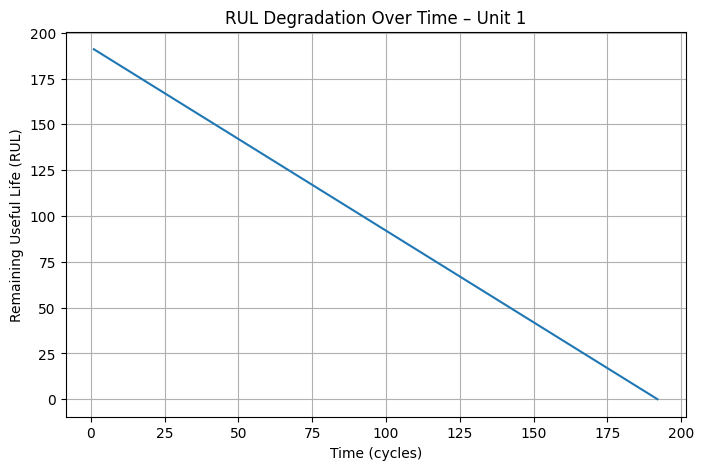

In [8]:
unit_example = 1  # you can change this
df_unit = df[df["unit"] == unit_example]

plt.plot(df_unit["time_cycles"], df_unit["RUL"])
plt.xlabel("Time (cycles)")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Degradation Over Time – Unit {unit_example}")
plt.show()


## 5. Analyze – Sensor Correlation With RUL

Next, we compute the correlation between each sensor and RUL.  
This mirrors the CORREL() calculations performed in Google Sheets.

We are especially interested in:
- Strong negative correlations (sensor value decreases as failure approaches)
- Strong positive correlations (sensor value increases when engine is healthy)


In [9]:
# Sensor columns
sensor_cols = [c for c in df.columns if c.startswith("sensor")]

# Compute correlations with RUL
correlations = (
    df[sensor_cols + ["RUL"]]
        .corr()["RUL"]
        .drop("RUL")
        .sort_values()
)

correlations


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


sensor_11   -0.696228
sensor_4    -0.678948
sensor_15   -0.642667
sensor_2    -0.606484
sensor_17   -0.606154
sensor_3    -0.584520
sensor_8    -0.563968
sensor_13   -0.562569
sensor_9    -0.390102
sensor_14   -0.306769
sensor_20    0.629428
sensor_21    0.635662
sensor_7     0.657223
sensor_12    0.671983
sensor_18         NaN
sensor_19         NaN
Name: RUL, dtype: float64

In [10]:
corr_df = correlations.reset_index()
corr_df.columns = ["sensor", "correlation_with_RUL"]
corr_df


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,sensor,correlation_with_RUL
0,sensor_11,-0.696228
1,sensor_4,-0.678948
2,sensor_15,-0.642667
3,sensor_2,-0.606484
4,sensor_17,-0.606154
5,sensor_3,-0.584520
6,sensor_8,-0.563968
7,sensor_13,-0.562569
8,sensor_9,-0.390102
9,sensor_14,-0.306769


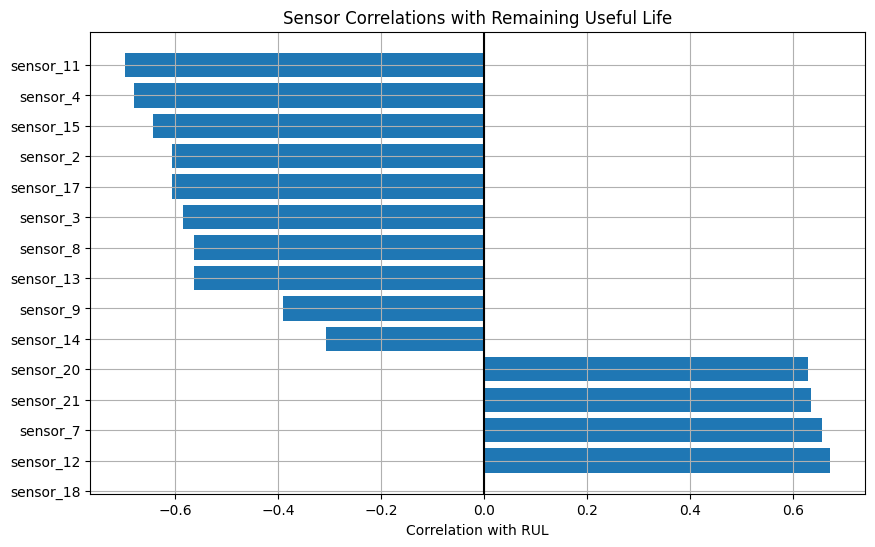

In [11]:
plt.figure(figsize=(10,6))
plt.barh(corr_df["sensor"], corr_df["correlation_with_RUL"])
plt.axvline(0, color="black")
plt.xlabel("Correlation with RUL")
plt.title("Sensor Correlations with Remaining Useful Life")
plt.gca().invert_yaxis()
plt.show()


## 6. Analyze – Key Sensors (Sensor 11 and Sensor 7)

From correlation analysis (both in Google Sheets and here in Python), the most predictive sensors for RUL include:

- **Sensor 11** – strong negative correlation with RUL  
- **Sensor 7** – strong positive correlation with RUL  

We’ll visualize each of these against RUL.


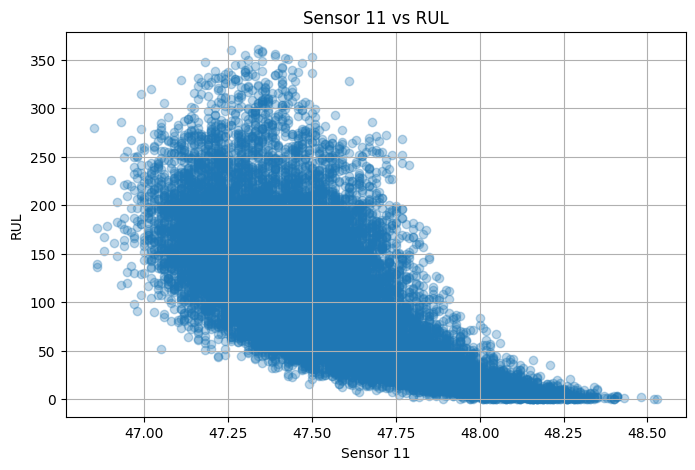

In [12]:
plt.scatter(df["sensor_11"], df["RUL"], alpha=0.3)
plt.xlabel("Sensor 11")
plt.ylabel("RUL")
plt.title("Sensor 11 vs RUL")
plt.show()


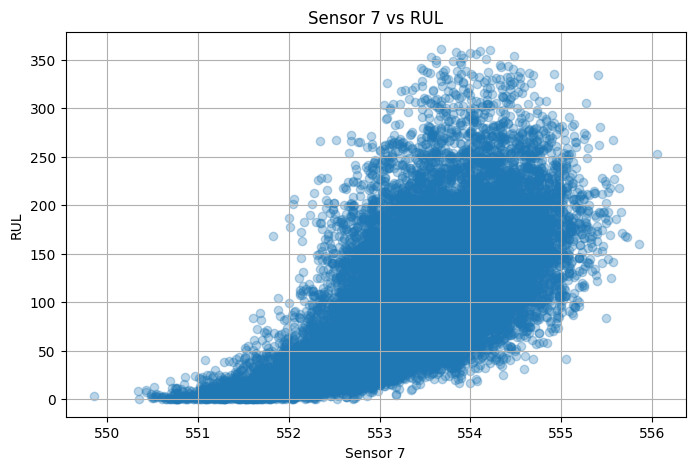

In [13]:
plt.scatter(df["sensor_7"], df["RUL"], alpha=0.3)
plt.xlabel("Sensor 7")
plt.ylabel("RUL")
plt.title("Sensor 7 vs RUL")
plt.show()


## 7. Share – Key Insights

**Key findings:**

- **Sensor 11** shows the strongest negative relationship with RUL.  
  As Sensor 11 values change, RUL declines more predictably, making it a strong early-warning indicator of failure.

- **Sensor 7** shows a strong positive relationship with RUL.  
  Higher Sensor 7 values tend to occur when engines have more remaining life.

- Together, these sensors provide complementary signals that can be used in a predictive maintenance model.


## 8. Act – Recommendations

Based on this analysis, the following actions are recommended:

1. **Monitor Sensor 11 and Sensor 7 in real time.**  
   Use threshold-based alerts when values cross risk levels.

2. **Transition toward condition-based maintenance.**  
   Prioritize engines showing sensor patterns associated with low RUL.

3. **Develop a predictive RUL model.**  
   Use Sensors 11, 7, 13, 4, and 8 as core features for a regression or machine learning model.

4. **Build a dashboard for maintenance teams.**  
   Visualize RUL estimates per engine and critical sensor readings.

5. **Expand the analysis with additional FD002–FD004 subsets.**  
   Validate model robustness across different operating conditions.


## 9. Conclusion

This notebook replicates and extends my original Google Sheets case study on the NASA FD001 turbofan dataset.  

By calculating RUL, analyzing sensor behavior, and computing correlations, I identified **Sensor 11** and **Sensor 7** as key predictors of engine degradation.  

These insights support predictive maintenance strategies that can reduce unplanned downtime, lower costs, and improve operational safety.
